# 1083 Albumin Initial ML

### By: Ian Weimer

## Imports

In [25]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
from imblearn.over_sampling import SMOTE, SMOTENC
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [26]:
df = pd.read_csv('K85_matched_2.csv')

In [27]:
# drop insignificant vars

#df.drop(columns = ['bed_size', 'Cirrhosis', 'tenant'], inplace=True)

In [28]:
df.head()

encounterid  ICU  Cirrhosis  CCI  qSOFA  SEWS  \
0  2dc21f88-780f-49ff-8869-9b859454cb25    1          0    0      1     1   
1  b41e918b-0767-41a8-97bd-cebb56dadb92    1          0    1      3     5   
2  c51a4a13-b8e9-4c35-bc11-c3443f668b06    1          0    0      1     2   
3  92e7d39f-a88c-48af-a64d-d7ad52cd08d0    0          1    4      1     1   
4  d2ea8946-63ac-46fc-b0cc-c41a31f2dda4    0          1    3      1     1   

   LVR  propensity_score  propensity_logit  albumin_24hrs  \
0    0          0.710132          0.896024              1   
1    0          0.975129          3.668856              1   
2    0          0.770494          1.211100              1   
3    0          0.886667          2.057142              1   
4    0          0.851459          1.746093              1   

                               personid   LOS_days  90_day_mortality  \
0  0101df2c-9e73-43f3-8a86-3804062428ea   2.841667                 0   
1  020382ec-fec4-4cfd-90a8-9648a9908768   3.568958                 0   
2  2659d580-6afc-4e49-b02c-cfdb6b417d3a  21.113889                 0   
3  28ca1cb5-ba48-49d2-9ea6-402605244827   6.850556                 0   
4  37dd3925-89b8-4f2f-ba94-ea913e692a00   6.551389                 0   

   90_day_readmission  hospital_free_days  albumin_timing  albumin  
0                 0.0                  87             2.0        1  
1                 1.0                  68             2.0        1  
2                 0.0                  29             1.0        1  
3                 1.0                  12             2.0        1  
4                 0.0                  84             2.0        1

In [29]:
df.shape

(6318, 17)

## Select Only Patients Who Lived (Removing Patients in 0 Class Who Died)

In [30]:
df = df.loc[df['90_day_mortality'] == 0]

In [31]:
df.shape

(5263, 17)

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [32]:
ra_90d_a24 = df[df['albumin_24hrs'] == 1]['90_day_readmission'].value_counts()
print(ra_90d_a24)

0.0    1459
1.0     962
Name: 90_day_readmission, dtype: int64


In [33]:
def binary_pct(var):
    pct = (var[1]/(var[1]+var[0])) * 100
    return pct

binary_pct(ra_90d_a24)

39.73564642709624

In [34]:
ra_90d = df[df['albumin_24hrs'] == 0]['90_day_readmission'].value_counts()
print(ra_90d)

0.0    1734
1.0    1108
Name: 90_day_readmission, dtype: int64


In [35]:
binary_pct(ra_90d)

38.98662913441239

In [36]:
df.drop(columns=['propensity_score', 'propensity_logit', 'encounterid', 'personid', 'albumin', 'albumin_timing'], inplace=True)

In [37]:
df.drop(columns=['90_day_mortality', 'LOS_days', 'hospital_free_days'], inplace=True)

In [38]:
# remove variables

# df.drop(columns=['mass_transfusion', 'anemia_status', 'qSOFA', 'hemorrhagic', 'bl_albumin_value', 'SAPS'], inplace=True)
# df.drop(columns=['qSOFA', 'bl_albumin_value', 'SAPS'], inplace=True)

In [39]:
df.describe()

ICU    Cirrhosis          CCI        qSOFA         SEWS  \
count  5263.000000  5263.000000  5263.000000  5263.000000  5263.000000   
mean      0.297929     0.376211     3.358921     0.721072     1.575527   
std       0.457392     0.484480     2.741803     0.783783     1.789775   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     1.000000     0.000000     0.000000   
50%       0.000000     0.000000     3.000000     1.000000     1.000000   
75%       1.000000     1.000000     5.000000     1.000000     2.000000   
max       1.000000     1.000000    15.000000     3.000000    10.000000   

               LVR  albumin_24hrs  90_day_readmission  
count  5263.000000    5263.000000         5263.000000  
mean      0.194186       0.460004            0.393312  
std       0.395610       0.498445            0.488531  
min       0.000000       0.000000            0.000000  
25%       0.000000       0.000000            0.000000  
50%       0.000000       0.000000            0.000000  
75%       0.000000       1.000000            1.000000  
max       1.000000       1.000000            1.000000

In [40]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

## Modeling

In [41]:
# establish target feature, LOS_days, as y feature
y = df['90_day_readmission']
# drop target feature from features dataframe
X = df.drop(columns = ['90_day_readmission'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [42]:
cols

Index(['ICU', 'Cirrhosis', 'CCI', 'qSOFA', 'SEWS', 'LVR', 'albumin_24hrs'], dtype='object')

## Standardize Data

In [43]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [44]:
X.head()

ICU  Cirrhosis  CCI  qSOFA  SEWS  LVR  albumin_24hrs
0    1          0    0      1     1    0              1
1    1          0    1      3     5    0              1
2    1          0    0      1     2    0              1
3    0          1    4      1     1    0              1
4    0          1    3      1     1    0              1

## Train Test Split

In [45]:
sm = SMOTENC(random_state=42, categorical_features = [0, 1, 3, 4, 5, 6])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [46]:
#sm = SMOTEN(random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [47]:
y_train.value_counts()

0.0    2540
1.0    2540
Name: 90_day_readmission, dtype: int64

In [48]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [49]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

Feature: ICU Score: 0.00652
Feature: Cirrhosis Score: 0.11137
Feature: CCI Score: 0.04339
Feature: qSOFA Score: 0.02408
Feature: SEWS Score: -0.01675
Feature: LVR Score: 0.07093
Feature: albumin_24hrs Score: 0.04807


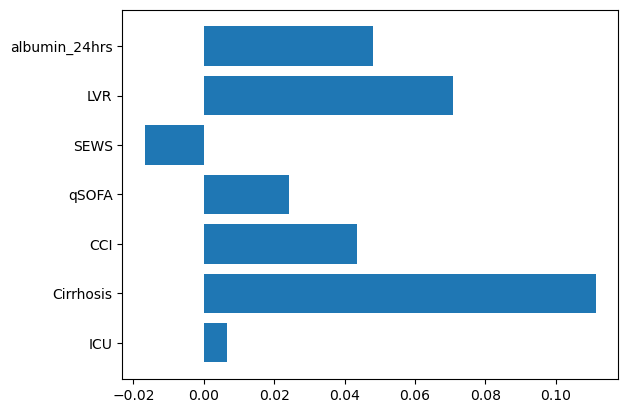

In [50]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

               Importance
Cirrhosis        1.117804
LVR              1.073507
albumin_24hrs    1.049245
CCI              1.044342
qSOFA            1.024367
ICU              1.006542
SEWS             0.983389


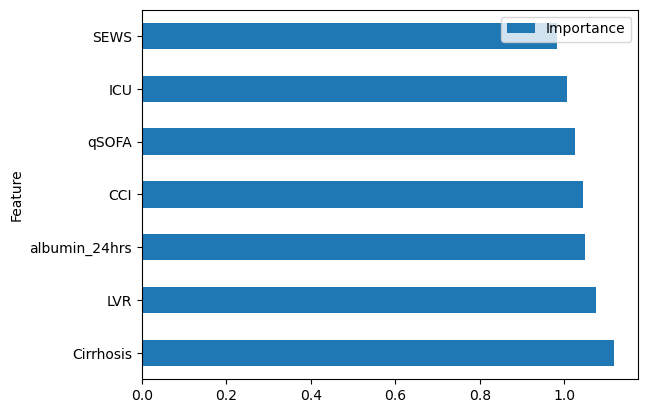

In [51]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [52]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [53]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1512 1028]
 [1159 1381]]


In [54]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

         0.0       0.57      0.60      0.58      2540
         1.0       0.57      0.54      0.56      2540

    accuracy                           0.57      5080
   macro avg       0.57      0.57      0.57      5080
weighted avg       0.57      0.57      0.57      5080



In [55]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[385 268]
 [184 216]]


In [56]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

         0.0       0.68      0.59      0.63       653
         1.0       0.45      0.54      0.49       400

    accuracy                           0.57      1053
   macro avg       0.56      0.56      0.56      1053
weighted avg       0.59      0.57      0.58      1053



## 5: Decision Tree 

In [57]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: ICU Score: 0.01867
Feature: Cirrhosis Score: 0.06563
Feature: CCI Score: 0.54357
Feature: qSOFA Score: 0.10487
Feature: SEWS Score: 0.17405
Feature: LVR Score: 0.01772
Feature: albumin_24hrs Score: 0.07549


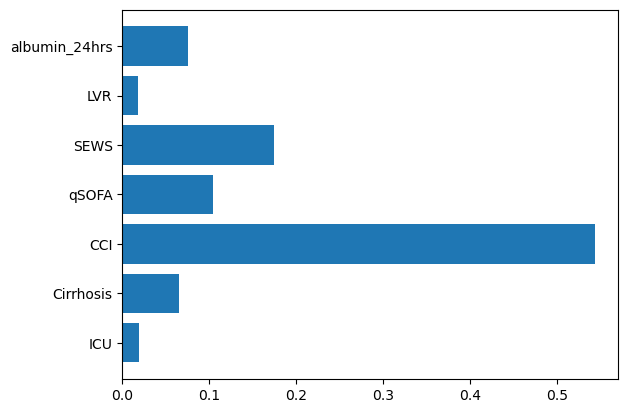

In [58]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [59]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [60]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1565  975]
 [1096 1444]]


In [61]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

         0.0       0.59      0.62      0.60      2540
         1.0       0.60      0.57      0.58      2540

    accuracy                           0.59      5080
   macro avg       0.59      0.59      0.59      5080
weighted avg       0.59      0.59      0.59      5080



In [62]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[385 268]
 [197 203]]


In [63]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

         0.0       0.66      0.59      0.62       653
         1.0       0.43      0.51      0.47       400

    accuracy                           0.56      1053
   macro avg       0.55      0.55      0.54      1053
weighted avg       0.57      0.56      0.56      1053



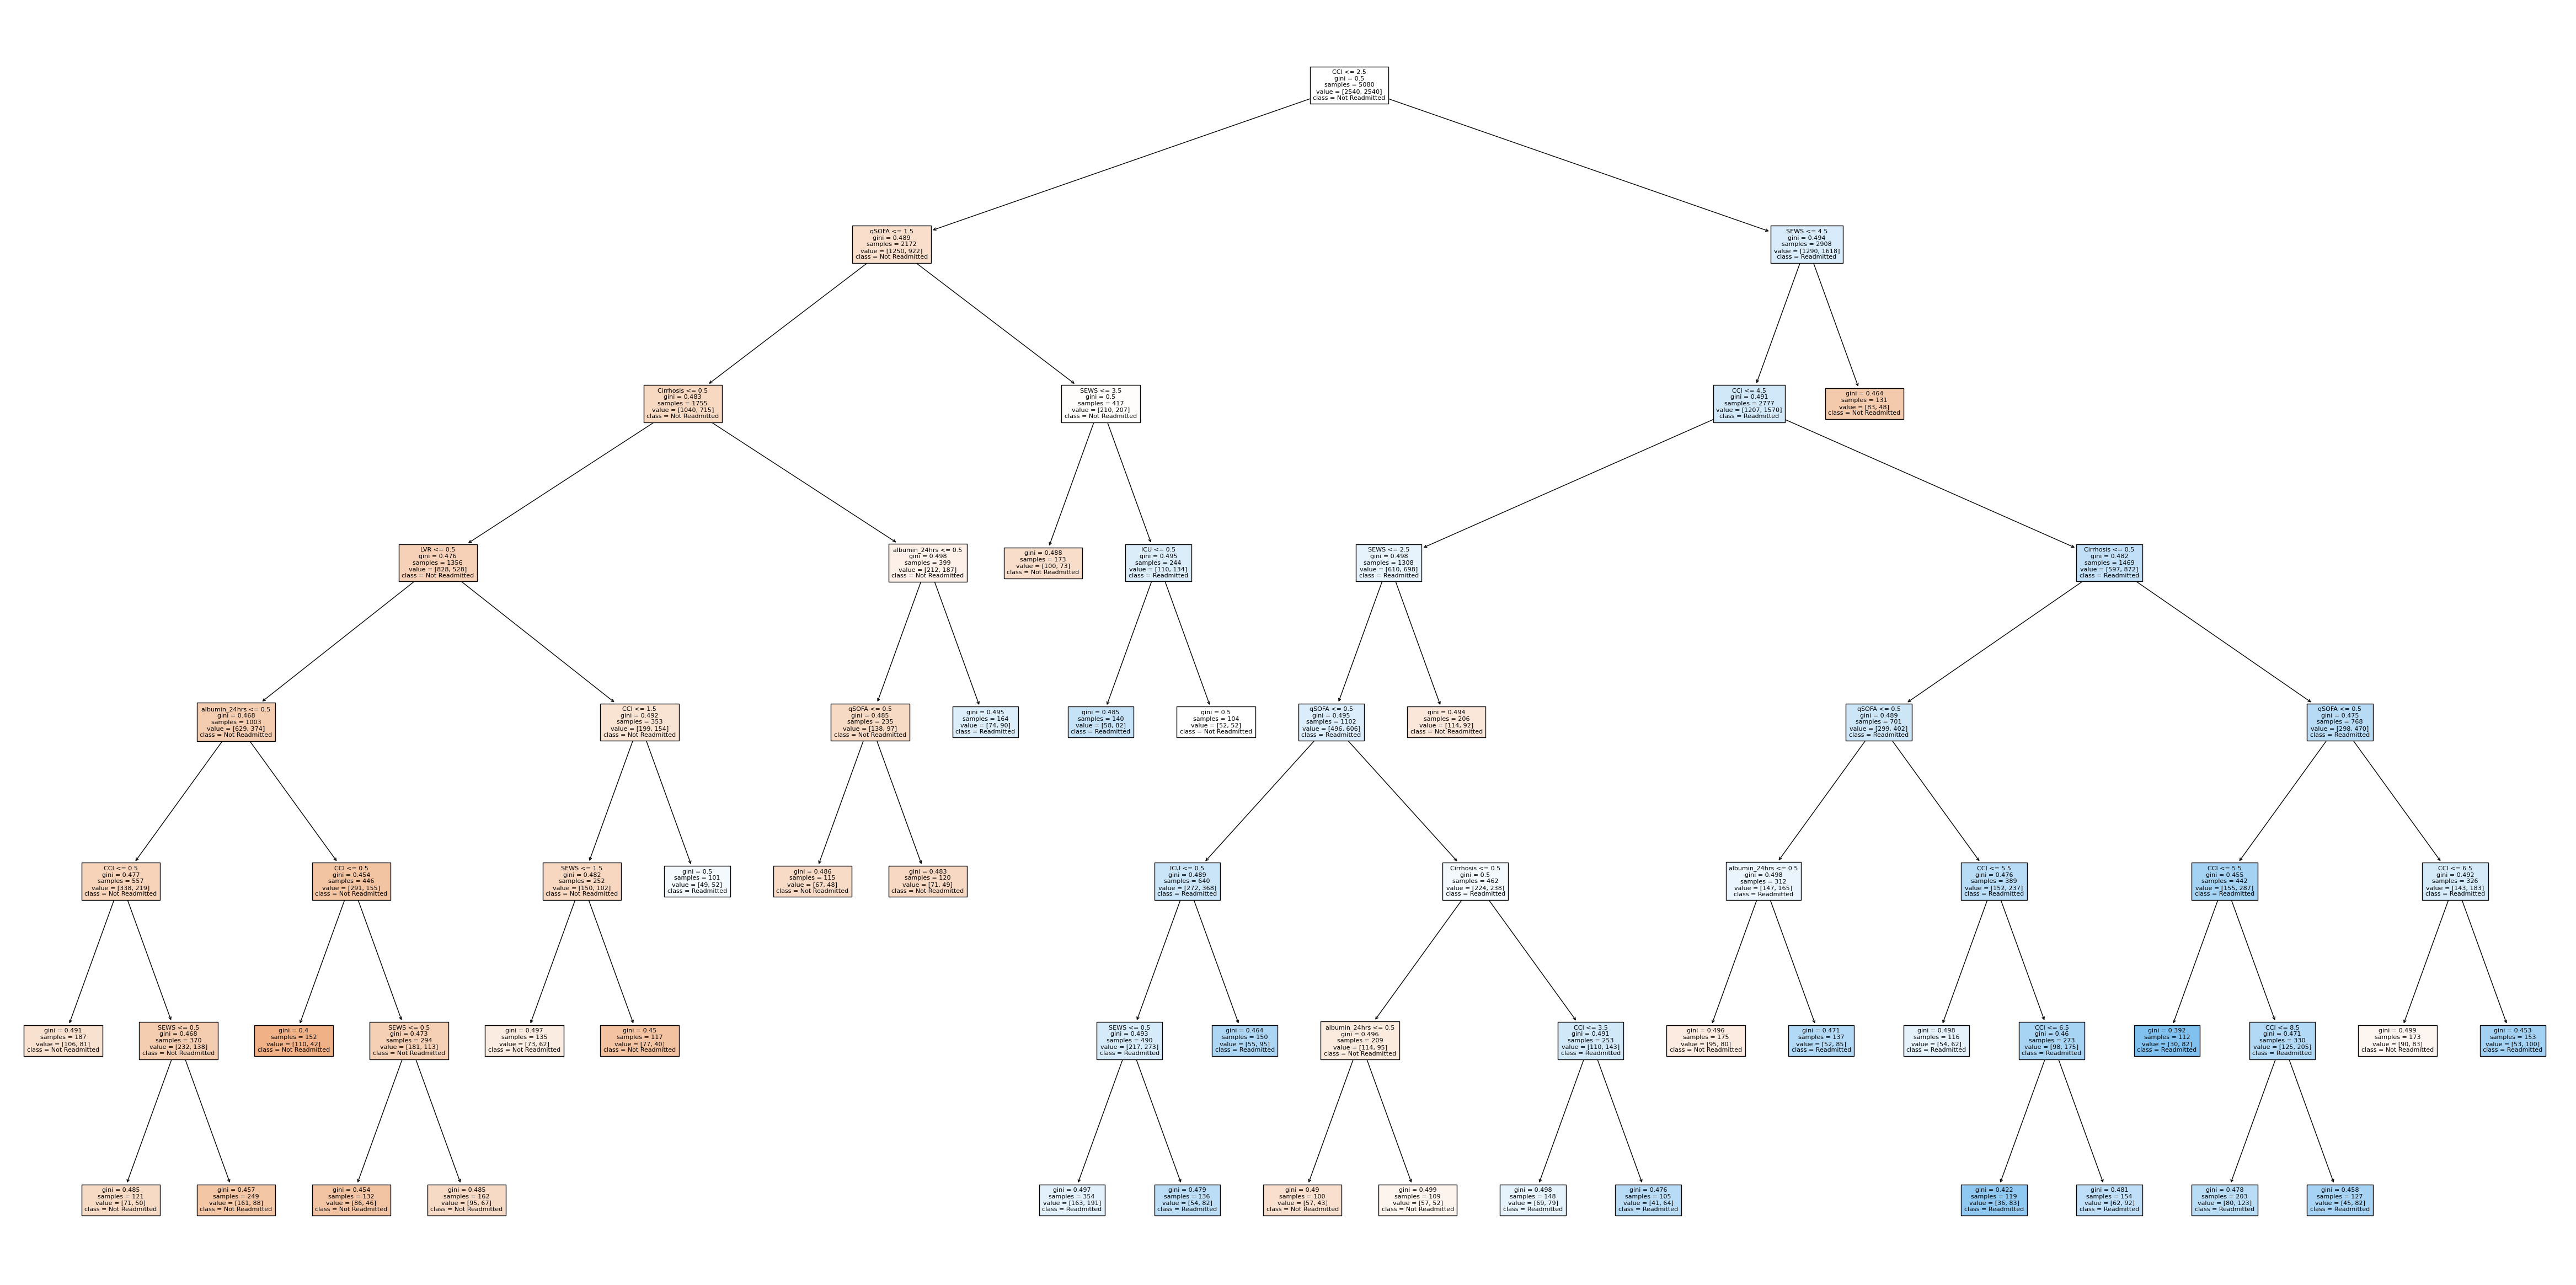

In [64]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [65]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('90DRA_DT_D7_PSM_MATCHED_3.png')

True

## Random Forest

In [66]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [67]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [68]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1445 1095]
 [1001 1539]]


In [69]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

         0.0       0.59      0.57      0.58      2540
         1.0       0.58      0.61      0.59      2540

    accuracy                           0.59      5080
   macro avg       0.59      0.59      0.59      5080
weighted avg       0.59      0.59      0.59      5080



In [70]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[367 286]
 [152 248]]


In [71]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

         0.0       0.71      0.56      0.63       653
         1.0       0.46      0.62      0.53       400

    accuracy                           0.58      1053
   macro avg       0.59      0.59      0.58      1053
weighted avg       0.61      0.58      0.59      1053



Feature: ICU Score: 0.02498
Feature: Cirrhosis Score: 0.16153
Feature: CCI Score: 0.54847
Feature: qSOFA Score: 0.07916
Feature: SEWS Score: 0.11875
Feature: LVR Score: 0.02599
Feature: albumin_24hrs Score: 0.04112


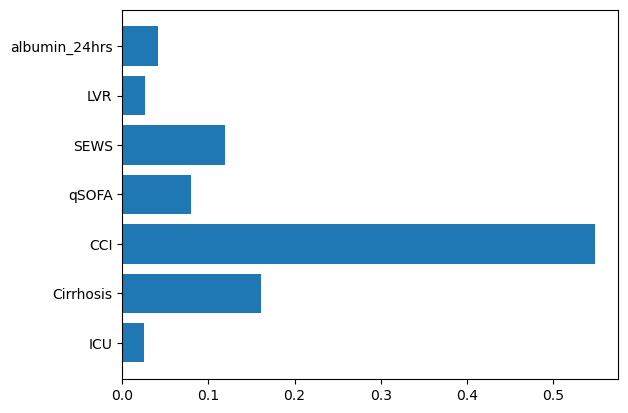

In [72]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()